In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:98% !important; }</style>")

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from importlib import reload

from tqdm import tqdm_notebook as tqdm
from joblib import Parallel, delayed

import lnPi
import lnPi.stability
reload(lnPi)

<module 'lnPi' from '/Users/wpk/Documents/python/lnPi/__init__.py'>

In [4]:
def tag_phases2(x):
    if len(x) > 2:
        raise ValueError('bad tag function')
    argmax0 = np.array([xx.local_argmax()[0] for xx in x])
    return np.where(argmax0 <= x[0].shape[0] / 2, 0, 1)
    

In [5]:
import lnPi.serieswrapper
reload(lnPi.serieswrapper)

import lnPi.xlnPi_vec
reload(lnPi.xlnPi_vec)
reload(lnPi.segment)
import lnPi.stability_vec
reload(lnPi.stability_vec)


/Users/wpk/Documents/python/lnPi/extensions.py:119: AccessorRegistrationWarning: registration of accessor <class 'lnPi.xlnPi_vec.xrlnPiVec'> under name 'xge' for type <class 'lnPi.serieswrapper.CollectionlnPi'> is overriding a preexisting attribute with the same name.
  cls._register_accessor(name, accessor, single_create)
/Users/wpk/Documents/python/lnPi/extensions.py:119: AccessorRegistrationWarning: registration of accessor <class 'lnPi.xlnPi_vec.xrlnPiVec'> under name 'vgce' for type <class 'lnPi.core.MaskedlnPi'> is overriding a preexisting attribute with the same name.
  cls._register_accessor(name, accessor, single_create)
/Users/wpk/Documents/python/lnPi/extensions.py:344: AccessorRegistrationWarning: registration of name 'wlnPi' for type <class 'lnPi.lnpicollections.CollectionPhases'> is overriding a preexisting attribute with the same name.
  return cls._register_listaccessor(names, accessor_wrapper=_CachedListAccessorWrapper, cache_list=cache_list)
/Users/wpk/Documents/pytho

<module 'lnPi.stability_vec' from '/Users/wpk/Documents/python/lnPi/stability_vec.py'>

In [7]:
ref = lnPi.MaskedlnPi.from_table('./nahs_asym_mix.11_11_03.r1.lnpi_o.dat', lnz=[0.5, 0.5], state_kws=dict(beta=1.0, volume=1.0)).pad()
phase_creator = lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=ref, tag_phases=tag_phases2, 
                                         merge_kws=dict(efac=0.8))

phase_creator_s = lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=ref, tag_phases=tag_phases2,
                                          phases_factory=lnPi.serieswrapper.CollectionlnPi.from_list,
                                         merge_kws=dict(efac=0.8))

In [8]:
def get_bin_spin(lnz2):
    build_phases = phase_creator.build_phases_mu([None, lnz2])
    lnzs = np.linspace(-8, 8, 20)
    c = lnPi.CollectionPhases.from_builder(lnzs, build_phases)
    t_spin = None
    t_bino = None
    
    try:
        c.spinodals(2, build_phases, inplace=True)
        c.binodals(2, build_phases, inplace=True)
        t_spin = c.spinodals.access.xge_prop.table(['molfrac'], edge_dist_ref=ref)
        t_bino = c.binodals.access.xge_prop.table(['molfrac'], edge_dist_ref=ref)
#         Lspin.append(c.spinodals.access.xge_prop.table(['molfrac']))
#         Lbino.append(c.binodals.access.xge_prop.table(['molfrac']))
    except:
        pass
    return t_spin, t_bino
    
    

In [9]:
out = Parallel(n_jobs=-1, backend='multiprocessing')(delayed(get_bin_spin)(lnz2) for lnz2 in tqdm(np.arange(-5, 5, 0.1)))

In [10]:
spin = xr.concat([s for s, b in out if s is not None], 'sample')
bino = xr.concat([b for s, b in out if b is not None], 'sample')

In [14]:
def get_bin_spin1(lnz2, phase_creator, from_builder, from_builder_kws=None):
    build_phases = phase_creator.build_phases_mu([None, lnz2])
    lnzs = np.linspace(-8, 8, 20)
    if from_builder_kws is None:
        from_builder_kws = {}
    c = from_builder(lnzs, build_phases, **from_builder_kws)
    t_spin = None
    t_bino = None
    
    try:
        c.spinodal(2, build_phases, inplace=True, unstack=False)
        c.binodal(2, build_phases, inplace=True, unstack=False)
        t_spin = c.spinodal.access.xge.table(['molfrac'], ref=ref)
        t_bino = c.binodal.access.xge.table(['molfrac'], ref=ref)
    except:
        pass
    return t_spin, t_bino


In [16]:
out1 = Parallel(n_jobs=-1, backend='multiprocessing')(delayed(get_bin_spin1)(lnz2, phase_creator_s, lnPi.serieswrapper.CollectionlnPi.from_builder) 
                                                     for lnz2 in tqdm(np.arange(-5, 5, 0.1)))


In [17]:
spin1 = xr.concat([s for s, b in out1 if s is not None], 'sample')
bino1 = xr.concat([b for s, b in out1 if b is not None], 'sample')

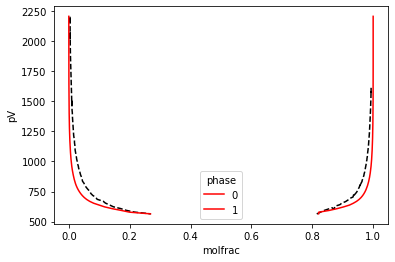

In [19]:
def plot_frame(df, **kws):
    (
        df
        .reset_index()
        .set_index(['molfrac','phase'])
        .assign(pV=lambda x: x['betapV'] / x['beta'])
        ['pV']
        .to_xarray()
        .plot(hue='phase', **kws)
    )

plot_frame(spin.to_dataframe().query('component==0 and rec==phase'), ls='--', color='k')
plot_frame(bino.to_dataframe().query('component==0'), color='r')

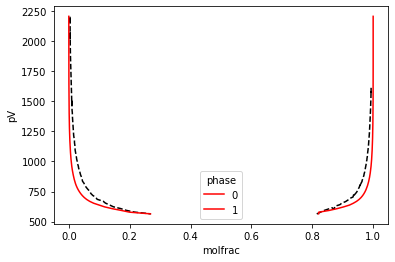

In [20]:
plot_frame(spin1.reset_index('sample').to_dataframe().query('component==0 and spinodal==phase').dropna(), ls='--', color='k')
plot_frame(bino1.reset_index('sample').to_dataframe().query('component==0').dropna(), color='r')

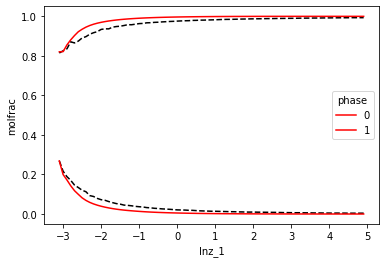

In [24]:
def plot_frame(df, **kws):
    (
        df
        .reset_index()
        .set_index(['lnz_1','phase'])
        .assign(pV=lambda x: x['betapV'] / x['beta'])
        ['molfrac']
        .to_xarray()
        .plot(hue='phase', **kws)
    )

plot_frame(spin.to_dataframe().query('component==0 and rec==phase'), ls='--', color='k')
plot_frame(bino.to_dataframe().query('component==0'), color='r')

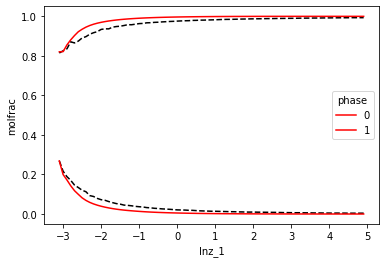

In [25]:
plot_frame(spin1.reset_index('sample').to_dataframe().query('component==0 and spinodal==phase').dropna(), ls='--', color='k')
plot_frame(bino1.reset_index('sample').to_dataframe().query('component==0').dropna(), color='r')

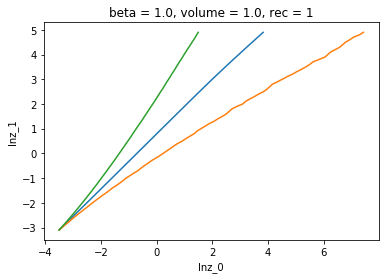

In [26]:
bino.sel(rec=0).lnz_1.swap_dims({'sample':'lnz_0'}).plot()

for rec in [0, 1]:
    (
        spin
        .pipe(lambda x: x.where(x.rec==x.phase))
        .lnz_1
        .sel(rec=rec)
        .swap_dims({'sample':'lnz_0'})
        .plot()


    )

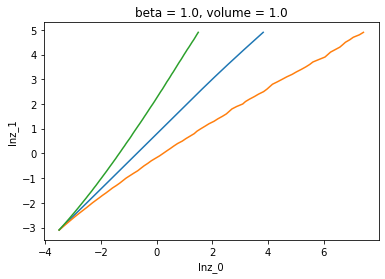

In [74]:
bino1.sel(binodal=0).lnz_1.reset_index('sample').swap_dims({'sample':'lnz_0'}).plot()

for s in [0,1]:
    (
        spin1
        .lnz_1
        .pipe(lambda x: x.sel(sample=x.spinodal==x.phase))
        .sel(spinodal=s)
        .reset_index('sample')
        .swap_dims({'sample':'lnz_0'})
        .plot()
    #     .reset_index('sample')
    #     .set_index(sample=['lnz_0','spinodal'])
    #     .unstack('sample')
    #     .plot(hue='spinodal')
    #    .swap_dims({'sample':'lnz_0'})

     )

/Users/wpk/.conda/envs/py37/lib/python3.7/site-packages/xarray/plot/plot.py:76: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  yplt = darray.transpose(xname, huename)


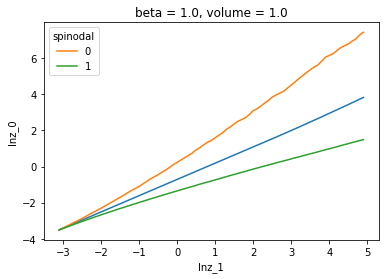

In [191]:
(
    bino1
    .lnz_0
    .reset_index(['lnz_0','phase'])
    .sel(binodal=0)
    .plot()

)

(
    spin1
    .lnz_0
    .pipe(lambda x: x.sel(sample=x.spinodal==x.phase))
    .reset_index(['lnz_0','phase'])
    .unstack('sample')
    .plot(hue='spinodal')
)